In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
#from torchmetrics.regression import MeanSquaredError

ROOT_DIR = "../"
from os.path import dirname, abspath,join
import sys
sys.path.append(ROOT_DIR)
from prochain_transformer.labels import *

INPUT_DIR,_,INTERMEDIATE_DIR,EXPERIMENTS_DIR = get_dirs(ROOT_DIR)

exp_id = "experiment_002"
OUTPUT_DIR = join(EXPERIMENTS_DIR,exp_id,"output")

In [2]:
#X_np = np.load(join(INPUT_DIR,"X_np.npy"))
#Y_np = np.load(join(INPUT_DIR,"Y_np.npy"))
output = torch.Tensor(np.load(join(OUTPUT_DIR,pred_output_filename)))
target = torch.Tensor(np.load(join(OUTPUT_DIR,pred_target_filename)))
cross_att = torch.Tensor(np.load(join(OUTPUT_DIR,pred_cross_attention_filename)))
cross_att_dimi = cross_att[:,0,:,:,:]

In [3]:
print(f"{output.shape} {target.shape} {cross_att.shape}")
print(f"{cross_att.shape} {cross_att_dimi.shape}")

torch.Size([993, 250]) torch.Size([993, 250]) torch.Size([993, 2, 4, 250, 3579])
torch.Size([993, 2, 4, 250, 3579]) torch.Size([993, 4, 250, 3579])


Min MSE 6.239450158318505e-05
Max MSE 0.048069197684526443


Text(0.5, 1.0, 'Test Dataset Errors')

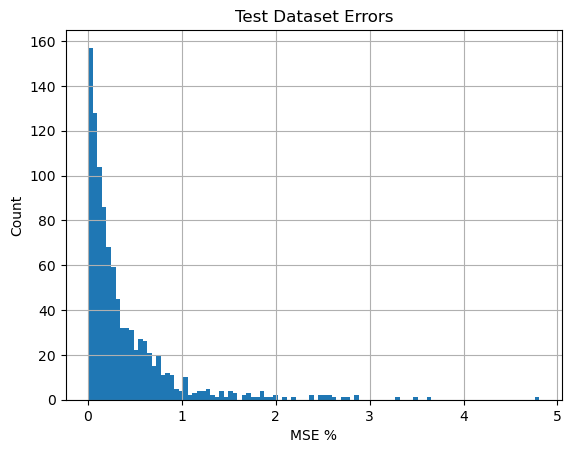

In [4]:
mse = nn.MSELoss(reduction="none")
error = torch.mean(mse(output, target),dim=1)
min_idx = torch.argmin(error)
max_idx = torch.argmax(error)
print(f"Min MSE {error[min_idx]}")
print(f"Max MSE {error[max_idx]}")

fig, ax = plt.subplots()
ax.grid(True)
ax.hist(error.numpy()*100,bins=100)
ax.set_xlabel("MSE %")
ax.set_ylabel("Count")
ax.set_title("Test Dataset Errors")

In [111]:
#id_selected = (max_idx,"Worst Sample")
id_selected = (min_idx,"Best Sample")

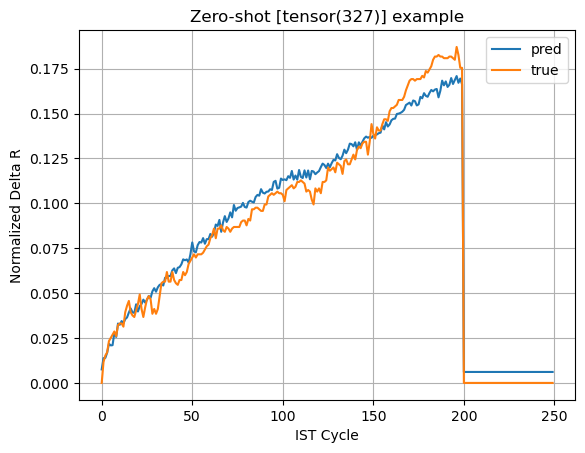

In [112]:
y_pred = output[[id_selected[0]]].numpy().astype(float)
y_true = target[[id_selected[0]]].numpy().astype(float)

fig, ax = plt.subplots()
ax.plot(np.arange(len(y_pred)),y_pred, label="pred")
ax.plot(np.arange(len(y_true)),y_true,label="true")
ax.set_xlabel("IST Cycle")
ax.set_ylabel("Normalized Delta R")
ax.set_title(f"Zero-shot {[id_selected[0]]} example")
ax.legend()
ax.grid(True)

In [113]:
cross_att_plot = cross_att[id_selected[0]][0,0,:,:]
cross_att_tot = torch.einsum('ihlk->ilk', cross_att_dimi)
cross_att_tot.shape

torch.Size([993, 250, 3579])

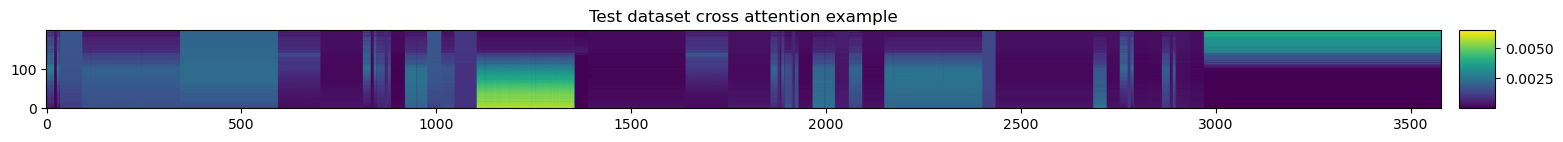

In [114]:
max_len_target = 200

fig, ax = plt.subplots(figsize=(18,8))
ax = plt.gca()
im = ax.imshow(cross_att_tot[id_selected[0]][:max_len_target,:],origin='lower')
ax.set_title("Test dataset cross attention example")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

In [115]:
df_tpl= pd.read_csv(join(INPUT_DIR,"Dyconex_01_01_240813","templates.csv"))

df_tpl

,SAP,Version,PaPos,Variable,AbsPos,Process
0,426816,C,40,las_11,0,Laser
1,426816,C,40,las_12,0,Laser
2,426816,C,40,las_13,0,Laser
3,426816,C,40,las_14,0,Laser
4,426816,C,40,las_15,0,Laser
...,...,...,...,...,...,...
16701,453828,B,80,gal_376,40,Galvanic
16702,453828,B,80,gal_377,40,Galvanic
16703,453828,B,80,gal_380,40,Galvanic
16704,453828,B,80,gal_381,40,Galvanic


In [116]:


for design in df_tpl[input_design_label].unique():
    for version in df_tpl[df_tpl[input_design_label]==design][input_version_label].unique():
        length = len(df_tpl.query(f'{input_design_label} == {design} and {input_version_label} == "{version}" '))
        print(f"{design} {version}: {length}")

426816 C: 1568
426816 D: 2863
436425 H: 629
436425 I: 1532
436425 J: 2971
449669 B: 484
449669 C: 3080
453828 B: 3579


In [ ]:
import matplotlib.patches as mpatches
design = 436425        
version = "J"

color_map = {
    'Laser': "#3B6592",
    'Plasma': '#F28E2B',
    'Galvanic': '#E15759',
    'Multibond': '#76B7B2',
    'Microetch': '#59A14F',
}

df_sel = df_tpl.set_index([input_design_label,input_version_label]).loc[design].loc[version]
df_sel["color"] = df_sel[input_process_label].map(color_map)
df_sel

,PaPos,Variable,AbsPos,Process,color
Version,,,,,
J,40,las_11,0,Laser,#4E79A7
J,40,las_12,0,Laser,#4E79A7
J,40,las_13,0,Laser,#4E79A7
J,40,las_14,0,Laser,#4E79A7
J,40,las_15,0,Laser,#4E79A7
...,...,...,...,...,...
J,680,mic_51,35,Microetch,#59A14F
J,680,mic_52,35,Microetch,#59A14F
J,680,mic_53,35,Microetch,#59A14F


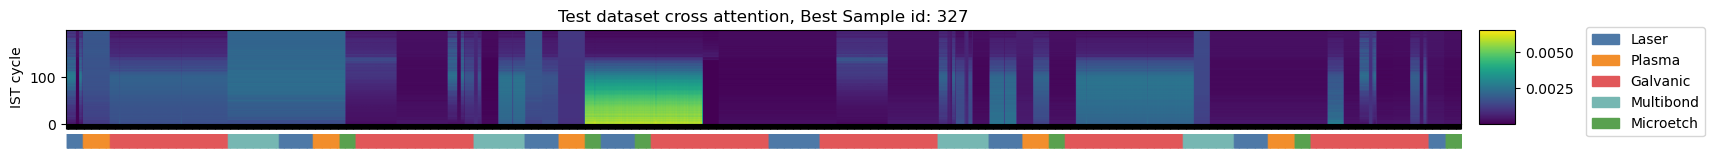

In [124]:


max_len_input = len(df_sel)
max_len_target = 200

process_steps = df_sel[input_process_label].values
colors = df_sel["color"].values

fig, ax = plt.subplots(figsize=(18,8))
ax = plt.gca()
im = plt.imshow(cross_att_tot[id_selected[0]][:max_len_target,:max_len_input],origin='lower')
ax.set_title(f"Test dataset cross attention, {id_selected[1]} id: {id_selected[0]}")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

ax.set_xticks(np.arange(max_len_input))
ax.set_xticklabels(['|'] * max_len_input, rotation=0, ha='center')
ax.set_ylabel("IST cycle")

for tick_label, color in zip(ax.get_xticklabels(), colors):
    tick_label.set_color(color)

# Set the ticks and colors
# for tick, color in zip(ax.get_xticks(), df_sel["color"]):
#     ax.tick_params(axis='x', which='both', colors=color)


# Create custom legend
unique_processes = df_sel[input_process_label].unique()
legend_patches = [mpatches.Patch(color=color_map[process], label=process) for process in unique_processes]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.18, 1.1), loc='upper right')

plt.colorbar(im, cax=cax)
plt.show()

In [125]:
cross_att_tot.shape

torch.Size([993, 250, 3579])

In [126]:
cross_att_tot.sum(axis=1).shape

torch.Size([993, 3579])

In [127]:
cross_att_tot_sum = cross_att_tot.sum(axis=1)
df_sel["Attention"] = cross_att_tot_sum[id_selected[0]][:max_len_input]

In [128]:
df_plot = pd.DataFrame(df_sel.groupby([input_step_label, input_process_label])["Attention"].mean().sort_values(ascending=False)).reset_index().set_index(input_process_label)
df_plot

,PaPos,Attention
Process,,
Microetch,480,0.945715
Laser,730,0.934022
Laser,700,0.903067
Microetch,660,0.891065
Multibond,180,0.589950
Laser,230,0.589950
Plasma,251,0.589950
Laser,240,0.589950
Laser,440,0.464536


C:\Users\ScipioneFrancesco\AppData\Local\Temp\ipykernel_17596\2531226154.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


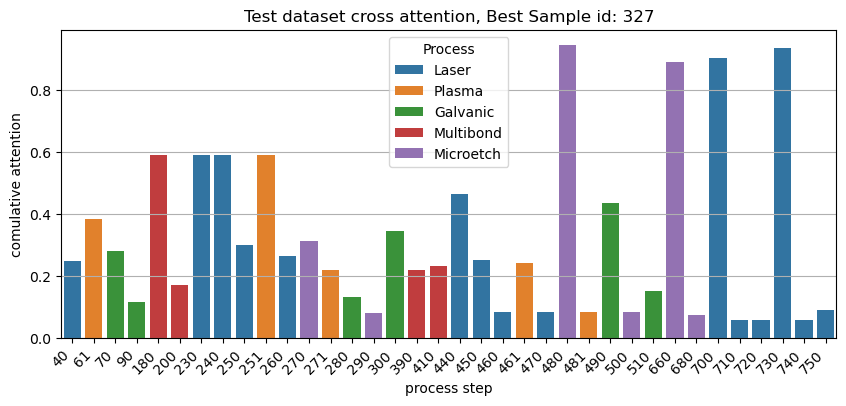

In [129]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.grid(True)
sns.barplot(df_plot, x=input_step_label,y="Attention",hue=input_process_label,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel("comulative attention")
ax.set_xlabel("process step")
ax.set_title(f"Test dataset cross attention, {id_selected[1]} id: {id_selected[0]}")
plt.show()